# Electricity Load Forecasting with Machine Learning

@LBNL by NH :thumbsup:

## Imports

In [1]:
import os, sys
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts.utils.statistics import check_seasonality, plot_acf, stationarity_tests
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.dataprocessing.transformers.diff import Diff
from darts.utils.statistics import plot_hist
from darts.models import LightGBMModel, XGBModel, LinearRegressionModel, TFTModel
from darts.metrics import smape, mape, mase, mse, rmse, r2_score, mae
from darts.dataprocessing.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler   
from darts.dataprocessing.transformers.scaler import Scaler

import wandb # log in through the terminal
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch

from utils import *


import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set working directory
os.chdir(r"..") # should be the git repo root directory
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"

#PATHS
RESULTS_PATH = r"results"
DATA_PATH = r"data"
MODEL_PATH = r"models"

Current working directory: c:\Users\nik\iCloudDrive\PhD_Icloud\PhD_Papers\Berkeley\WattCast


## 0) Loading the data

In [3]:
# Grabbing locations from the data folder
locations = get_locations(DATA_PATH)

# Electricity Load data (target)
df_list = []
for location in locations:
    df = load_data(DATA_PATH, location, data_type='power')
    df = drop_duplicate_index(df)
    df.columns = [location]
    df_list.append(df)

df_load = pd.concat(df_list, axis=1)

freq = infer_frequency(df_load)
print(f'The frequency of the data is {freq}.')

ts_list = []
for location in locations:
    ts = darts.TimeSeries.from_dataframe(df_load[[location]], freq=freq)
    ts.name = location
    ts_list.append(ts)


# Weather data (covariates)
ts_list_weather = []
for location in locations:
    df = load_data(DATA_PATH= DATA_PATH, location= location, data_type='weather')
    df = drop_duplicate_index(df)
    ts = darts.TimeSeries.from_dataframe(df, freq=freq)
    ts.name = location
    ts_list_weather.append(ts)



The frequency of the data is 0 days 01:00:00.


## 1) Exploratory Data Analysis (EDA) & Data Cleaning

In [5]:
df_load.describe()

la            ny           sac
count  45929.000000  45979.000000  45928.000000
mean    3213.984563  18047.904043   2010.438796
std      745.861634   3447.283270    535.579632
min     1942.000000  11371.000000   1240.000000
25%     2670.000000  15572.000000   1670.000000
50%     3089.000000  17710.000000   1878.000000
75%     3511.000000  19792.000000   2127.000000
max     7095.000000  32076.000000   4858.000000

In [7]:
df_load.isna().sum() / len(df_load) # percentage of missing values for each location -> seems clean

la     0.001087
ny     0.000000
sac    0.001109
dtype: float64

In [10]:
# a plot with plotly express that plots the missing values for each location in a separate subplot
px.line(df_load.isna(), title='Missing values')
#seems like the missing values are nicely distributed over the time series, so we can just impute them with interpolation

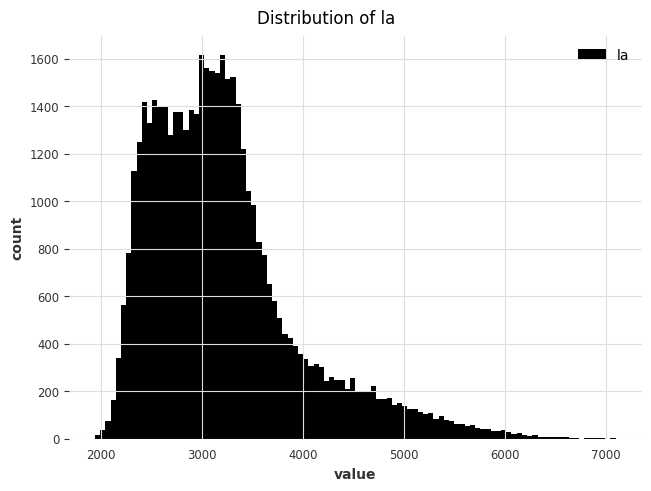

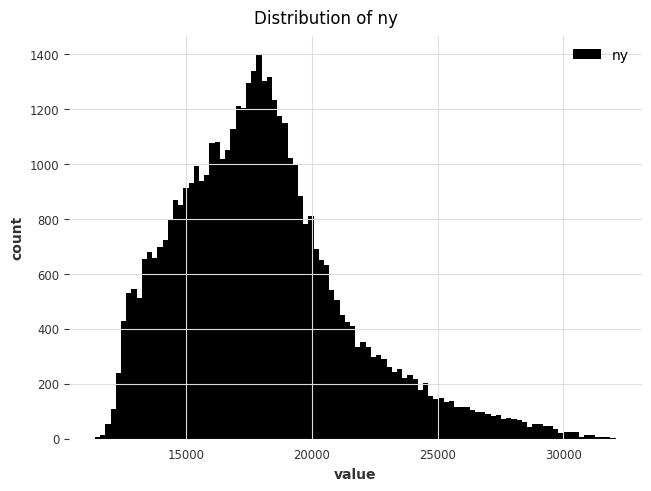

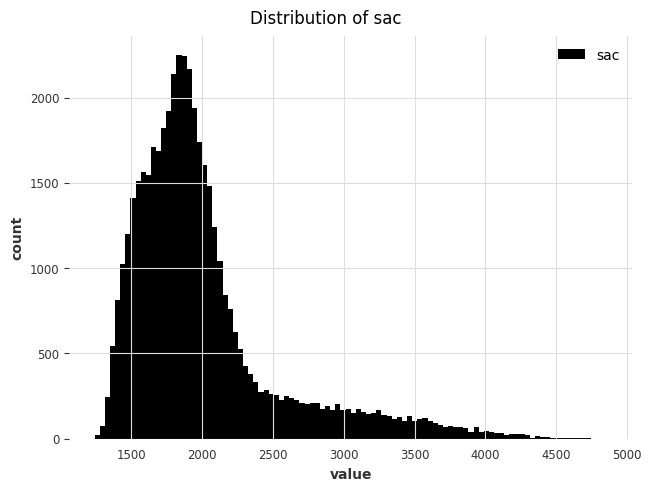

In [13]:
#Checking the distribution of the data, we see that the data is not normally distributed, but has a long/fat tail. 
#This motivates the us of a box-cox transformation.
for ts in ts_list:
    plot_hist(ts, bins=100, title=f'Distribution of {ts.name}')

## 2) Modeling

### Train, validation, test split

In [4]:
IDX = 0 # index of the location we want to train the model on
# print which location was selected by idx
print(f'Location is {locations[IDX]}')

# we will make the split 70-15-15

ts_length = len(ts_list[IDX])
train_end = int(0.7 * ts_length)
val_end = int(0.85 * ts_length)

train_end = ts_list[IDX].get_timestamp_at_point(train_end)
val_end = ts_list[IDX].get_timestamp_at_point(val_end)

ts_train_list, ts_val_list, ts_test_list = train_val_test_split(ts_list, train_end, val_end)
ts_train_weather_list, ts_val_weather_list, ts_test_weather_list = train_val_test_split(ts_list_weather, train_end, val_end)


# pretty print the first and last index of "la"
print(f'First index: {ts_list[IDX].start_time()}. Last index: {ts_list[IDX].end_time()}.')
print(f'Train end: {ts_train_list[IDX].end_time()}. Validation end: {ts_val_list[IDX].end_time()}. Test end: {ts_test_list[IDX].end_time()}.')
print(f'Train length: {len(ts_train_list[IDX])}. Validation length: {len(ts_val_list[IDX])}. Test length: {len(ts_test_list[IDX])}.')




Location is la
First index: 2015-07-02 00:00:00. Last index: 2020-09-28 23:00:00.
Train end: 2019-03-04 04:00:00. Validation end: 2019-12-16 14:00:00. Test end: 2020-09-28 23:00:00.
Train length: 32189. Validation length: 6899. Test length: 6898.


### Data Pipeline

This will be an invertible data pipline that transforms the data from the original form to the form that the model expects, and then back to the original form.
The pipeline includes the following steps, in the fashion we saw before:
1. Missing values imputation
2. BoxCox transformation
3. Differencing
4. Scaling



In [5]:
# Target pipeline
pipeline = Pipeline(
                    [
                    MissingValuesFiller(),
                    BoxCox(), 
                    Scaler(MinMaxScaler()),
                    ]
                     )


ts_train_list_piped = pipeline.fit_transform(ts_train_list)
ts_val_list_piped = pipeline.transform(ts_val_list)
ts_test_list_piped = pipeline.transform(ts_test_list)

# Weather Pipeline
pipeline_weather = Pipeline([MissingValuesFiller() ,Scaler(RobustScaler())])
ts_train_weather_list_piped = pipeline_weather.fit_transform(ts_train_weather_list)
ts_val_weather_list_piped = pipeline_weather.transform(ts_val_weather_list)
ts_test_weather_list_piped = pipeline_weather.transform(ts_test_weather_list)



### Model Creation

In [6]:
trg, covs = make_index_same(ts_test_list_piped[IDX], ts_test_weather_list_piped[IDX])
trg_inversed = pipeline.inverse_transform(trg, partial=True) # inverse transform the target, we need the original values for the evaluation

N_LAGS = 36 # timesteps lookback
N_AHEAD = 24 # timesteps horizon
LIKLIHOOD = None

encoders = {
            "cyclic": {"future": ["hour"]}, 
            "position": {"future": ["relative",]},
            "datetime_attribute": {"future": ["dayofweek", "week"]}
            }


Scikit & Co

In [7]:
model_lgb = LightGBMModel(lags=N_LAGS,
                      lags_future_covariates=[0],
                      add_encoders=encoders, 
                      output_chunk_length=N_AHEAD, 
                      likelihood=LIKLIHOOD)

model_xgb = XGBModel(lags=N_LAGS,
                      lags_future_covariates=[0],
                      add_encoders=encoders, 
                      output_chunk_length=N_AHEAD, 
                      likelihood=LIKLIHOOD)


model_lr = LinearRegressionModel(lags=N_LAGS,
                      lags_future_covariates=[0],
                      add_encoders=encoders, 
                      output_chunk_length=N_AHEAD, 
                      likelihood=LIKLIHOOD)


list_sklearn_models= [
                        model_lgb,
                        model_xgb, 
                        model_lr
                        ]

numer_of_sklearn_models = len(list_sklearn_models)

Deep Learning

In [8]:
# Using weights and biases for logging
run = wandb.init(project="load_forecasting_lbl", reinit=True)

wandb_logger = WandbLogger(reinit=True, log_model="all")

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

# set the device to gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# set the kwargs for the pytorch lightning trainer
pl_trainer_kwargs = {
                    "accelerator": device, 
                    "gpus": [0], 
                    "auto_lr_find":True, 
                    "logger": wandb_logger, 
                    "callbacks":[
                                    early_stopping
                                ],
                    "precision": 8,
                    }

MODEL_CLASS = TFTModel
model_tft = MODEL_CLASS(
                    model_name = run.id,
                    input_chunk_length=N_LAGS,
                    output_chunk_length=N_AHEAD,
                    add_encoders=encoders,
                    hidden_size=64,
                    pl_trainer_kwargs=pl_trainer_kwargs,
                    save_checkpoints = True,
                    work_dir=MODEL_PATH, # This is necessary for proper imports of the model
                    )


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben. Use `wandb login --relogin` to force relogin


In [10]:
model_tft.fit(ts_train_list_piped,
            future_covariates= ts_train_weather_list_piped, 
            val_series = ts_val_list_piped, 
            val_future_covariates= ts_val_weather_list_piped, 
            verbose=True, 
            epochs = 50,
            num_loader_workers =2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 14.3 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 12.5 K
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
# Download the model from wandb
run = wandb.run
run_id = "8r0d7gn2"
artifact_dir = run.use_artifact(f'nikolaushouben/load_forecasting_lbl/model-{run_id}:best_k', type='model').download()
base_path = os.path.join(MODEL_PATH, run_id, "_model.pth.tar")
checkpoint_path = f"{artifact_dir}\model.ckpt"
model = load_from_model_artifact_checkpoint(MODEL_CLASS, base_path, checkpoint_path)

wandb:   1 of 1 files downloaded.  


Training Slearn Models

In [12]:
# Train the models
models = train_models(list_sklearn_models, 
                        ts_train_list_piped[0], 
                        ts_train_weather_list_piped[0]
                        )


In [21]:
models.append(model) # add the tft model to the list of models if it was trained
model_names = [model.__class__.__name__ for model in models]

In [ ]:
# Generating Historical Forecasts for each model

ts_predictions_per_model = {}
historics_per_model = {}


for model in models:
    model_params = model.model_params # For future reference, when same algorithms are trained with different parameters
    model_name = model.__class__.__name__
    historics = model.historical_forecasts(trg, 
                                        future_covariates= covs,
                                        start=ts_test_list_piped[IDX].get_index_at_point(N_LAGS),
                                        verbose=True,
                                        stride=N_AHEAD // 4, 
                                        forecast_horizon=N_AHEAD, 
                                        retrain=False, 
                                        last_points_only=False, # leave this as False unless you want the output to be one series, the rest will not work with this however
                                        #num_samples=30 # only enable when using quantile regression likelihood
                                        )
    
    historics_per_model[model_name] = historics # storing the forecasts in batches of the forecasting horizon, for plot 1
    ts_predictions = ts_list_concat(historics) # concatenating the batches into a single time series for plot 2
    ts_predictions_inverse = pipeline.inverse_transform(ts_predictions, partial=True) # inverse transform the predictions, we need the original values for the evaluation
    ts_predictions_per_model[model_name] = ts_predictions_inverse

## 3) Model Evaluation

### Plot I: Error Score across forecast horizon:

:+1: The objective of the plot below is to see how the error score evolves over the forecast horizon.
To do so, we align the predictions in a way that the first prediction of each forecast is aligned with the first ground truth value, the second prediction is aligned with the second ground truth value, and so on. Note that the number of forecasts depends on the argument: 'stride' in the "
We then compute the error score for each prediction and plot the results.
Lastly we need to divide by the average of the ground truth values to get the relative error score. This accounts for the fact that the ground truth values are not constantm

In [50]:

df_smapes_per_model = []
df_nrmse_per_model = []

for model_name, historics in historics_per_model.items():
    df_list = get_df_compares_list(historics, trg)
    means_per_timestep = pd.concat(df_list, axis=1).filter(like = "gt").mean(axis=1).values # mean of the ground truth values on a timestep basis
    diffs = get_df_diffs(df_list)
    df_smapes = abs(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis
    df_nrmse = np.square(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis

    df_smapes_per_model.append(df_smapes)
    df_nrmse_per_model.append(df_nrmse)

df_smapes_per_model = pd.concat(df_smapes_per_model, axis=1)
df_nrmse_per_model = pd.concat(df_nrmse_per_model, axis=1)



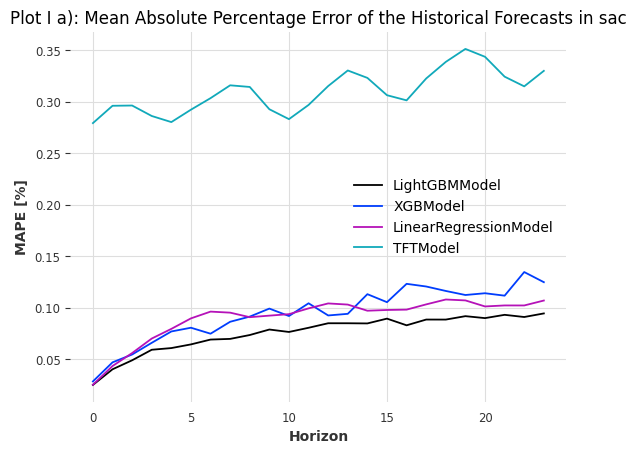

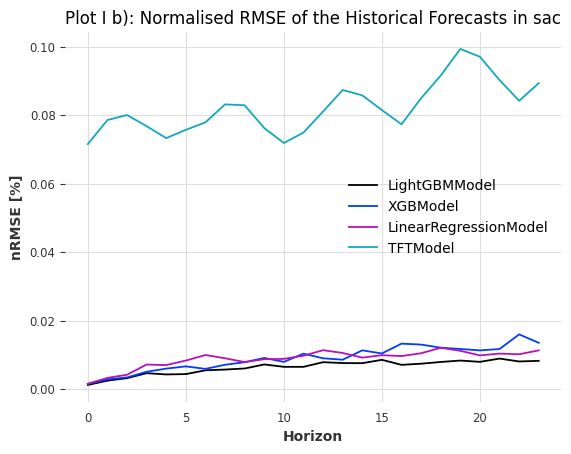

In [51]:
df_smapes_per_model.columns = model_names
df_smapes_per_model.plot()
plt.xlabel('Horizon')
plt.ylabel('MAPE [%]')
plt.legend()
plt.title(f"Plot I a): Mean Absolute Percentage Error of the Historical Forecasts in {locations[IDX]}")
plt.savefig(f"{RESULTS_PATH}//figs_nh//{locations[IDX]}//smape.png")

df_nrmse_per_model.columns = model_names
df_nrmse_per_model.plot()
plt.xlabel('Horizon')
plt.ylabel('nRMSE [%]')
plt.legend()
plt.title(f"Plot I b): Normalised RMSE of the Historical Forecasts in {locations[IDX]}")
plt.savefig(f"{RESULTS_PATH}//figs_nh//{locations[IDX]}//nrmse.png")

### Plot II: Side-by-side comparison of the predictions and the ground truth

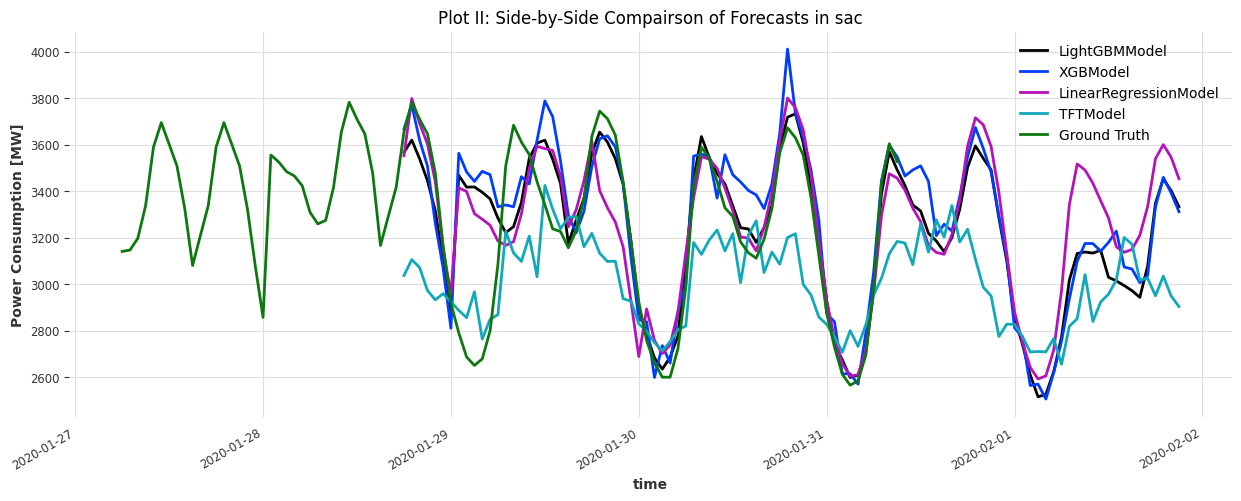

In [52]:
window_start = 1000
window_end = 1100


for model_name, ts_predictions_inverse in ts_predictions_per_model.items():
    ts_predictions_inverse[window_start:window_end].plot(label = model_name)

trg_inversed[window_start:window_end].plot(label='Ground Truth')
plt.title(f"Plot II: Side-by-Side Compairson of Forecasts in {locations[IDX]}")
plt.legend()
plt.ylabel('Power Consumption [MW]')
# adjust the figure size
plt.gcf().set_size_inches(15, 5)
plt.savefig(f"{RESULTS_PATH}//figs_nh//{locations[IDX]}//comparisons.png")



### Plot III: Interactive Side-by-Side Comparison of the Forecasts and the Ground Truth

You can select the time you want to look at closer by drawing up a window with your mouse (click and move horizontally)

In [53]:

df_forecasts_all_models = []

for model_name, ts_predictions_inverse in ts_predictions_per_model.items():

    df_forecasts = ts_predictions_inverse.pd_dataframe()
    df_forecasts.columns = ['Forecast: {}'.format(model_name)]
    df_forecasts_all_models.append(df_forecasts)

df_forecasts_all_models = pd.concat(df_forecasts_all_models, axis=1)

df_gt = trg_inversed.pd_dataframe()
df_gt.columns = ['Ground truth']
df_compare = pd.concat([df_forecasts_all_models, df_gt], axis=1)
px.line(df_compare, title='Forecast vs. Ground Truth: {}'.format(locations[IDX]))  

### Plot IV: Raw Error distribution

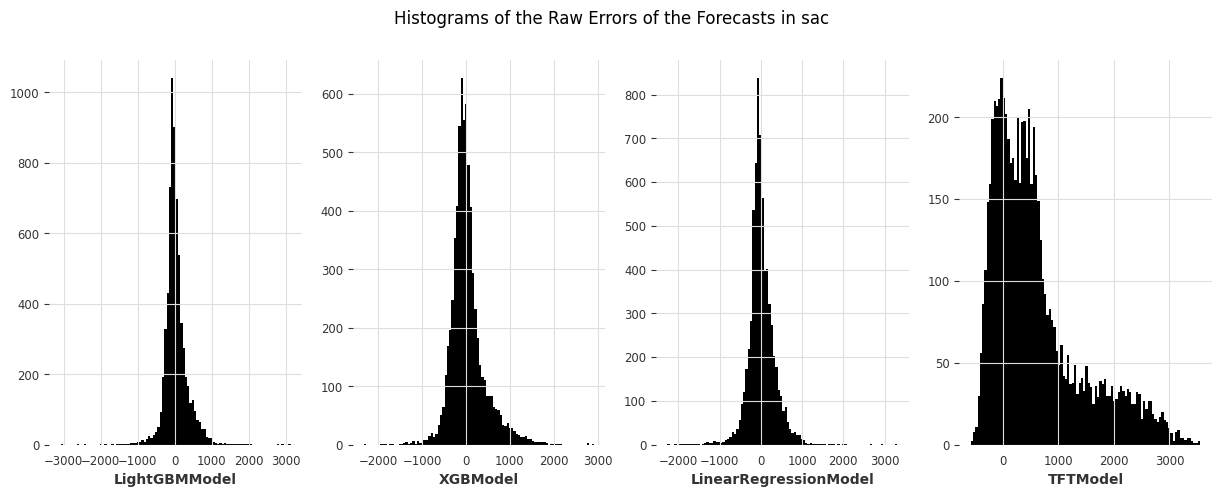

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 5))

for i, (model_name, ts_predictions_inverse) in enumerate(ts_predictions_per_model.items()):
    
    ts_predictions_inverse, trg_inversed = make_index_same(ts_predictions_inverse, trg_inversed)
    errors = trg_inversed.values() - ts_predictions_inverse.values()
    ax[i].hist(errors, bins=100, label=model_name)
    #start a new plot
    ax[i].set_xlabel(model_name)

# set the title of the figure
fig.suptitle('Histograms of the Raw Errors of the Forecasts in {}'.format(locations[IDX]))
fig.savefig(f"{RESULTS_PATH}//figs_nh///{locations[IDX]}//error_distribution.png")

### Table of Error Metrics